<a href="https://colab.research.google.com/github/yg-renaissance/movie-review-sentiment/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [2]:
!pip install konlpy

!pip install Mecab

!pip install eunjeon 

!pip install gensim

In [74]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding ,Flatten
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb

import numpy
import tensorflow as tf
import matplotlib.pyplot as plt

In [31]:
import gensim

In [3]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter
# 데이터를 읽어봅시다. 
train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')


In [220]:
import tensorflow as tf
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [136]:
pd.set_option('display.max_rows',300)

In [7]:
train_data[:100]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
95,8763660,어내스트와 셀레스틴 완전 강추에요~ 정말 재밌습니다^^,1
96,9361974,재미있는영화입니다.,1
97,7928957,클라라볼라고화신본거아닌데,0
98,10250221,진짜 보면서 너무 슬펐던 영화다,1


### Preprocessing

In [14]:
from eunjeon import Mecab
# from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
index_to_word = {index:word for word, index in word_to_index.items()}

In [86]:
set_size = len(index_to_word)

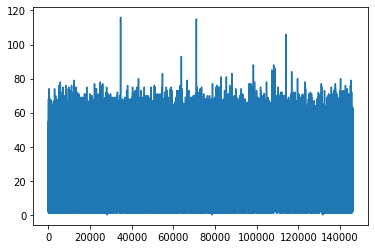

In [73]:
#### maxlen은 80이 appropriate 하겠군
ser = []
for x in range(len(X_train) ) :
    ser.append(len(X_train[x]))
plt.plot( list(range(len(ser))), ser)

{'whiskers': [<matplotlib.lines.Line2D at 0x27c696cd278>,
 'caps': [<matplotlib.lines.Line2D at 0x27c696cd828>,
 'boxes': [<matplotlib.lines.Line2D at 0x27c696aefd0>],
 'medians': [<matplotlib.lines.Line2D at 0x27c696cddd8>],
 'fliers': [<matplotlib.lines.Line2D at 0x27c699be0f0>],
 'means': []}

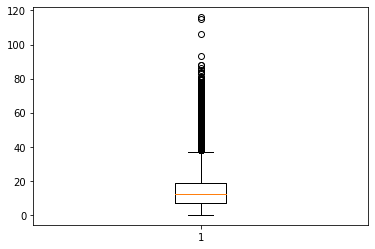

In [78]:
#### 아니다 85 로 가자
plt.boxplot(ser)

In [80]:
# 데이터 전처리
max_len = 85
xtr = sequence.pad_sequences(X_train, maxlen=max_len)
xte = sequence.pad_sequences(X_test, maxlen=max_len)

### model0 : 임베딩층 + conv + lstm (임베딩 아쉽)

In [87]:
# 모델의 설정
model = Sequential()
model.add(Embedding(set_size, 100))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

# 모델의 컴파일
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 모델의 실행
history = model.fit(xtr, y_train, batch_size=100, epochs=5, validation_data=(xte, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          32064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 55)                26400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 56        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                

In [89]:
model.save('./model/basic-embedding-lstm.h5')

In [98]:
model.evaluate(xte, y_test)

1537/1537 [==============================] - 8s 5ms/step - loss: 0.3503 - accuracy: 0.8547


[0.3503284454345703, 0.8547307848930359]

### model1 : pre-trained word2vec embedding 

In [108]:
len(train_data['id'].unique()) , len(train_data) # 중복 없음

(146183, 146183)

In [42]:
word2vec_file_path = './model/kow2v/ko.bin'
ko_model = gensim.models.Word2Vec.load(word2vec_file_path)
# ko_model.wv.most_similar("강아지")

vector_size = len(ko_model.wv['아무']) #200
vocab_size  = len(index_to_word) #10000

embedding_matrix = np.zeros((vocab_size, vector_size))
np.shape(embedding_matrix)

def get_vector(word):
    if word in ko_model.wv:
        return ko_model.wv[word]
    else:
        return None

num = 0
not_used = []
for word, i in word_to_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.
    else :
        not_used.append(word)
        num+=1

In [175]:
num/vocab_size   # pre-trained 하고 매칭이 안되는 게 40 % 나 육박한다 띠부럴...일단 직진...

0.4163

##### pre-trained 의 데이터셋이 작거나 vs 전처리 거시기 하게했거나

In [204]:
ko_model.wv.vectors.shape #3만개라.. hmm...i think it's little bit small..

(30185, 200)

In [214]:
model1 = Sequential()
e = Embedding(vocab_size, vector_size, weights=[embedding_matrix], input_length=max_len, trainable=False)
model1.add(e)
# model1.add(Flatten())
# model.add(Dropout(0.5))
model1.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model1.add(MaxPooling1D(pool_size=4))
model1.add(LSTM(55))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [221]:
model1.fit(xtr, y_train, batch_size=100, epochs=5, verbose=1,validation_data=(xte, y_test)
           ,callbacks=[tensorboard_callback])

Epoch 1/5
1462/1462 [==============================] - 77s 53ms/step - loss: 0.4506 - acc: 0.7828 - val_loss: 0.4489 - val_acc: 0.7826
Epoch 2/5
1462/1462 [==============================] - 73s 50ms/step - loss: 0.4110 - acc: 0.8054 - val_loss: 0.4399 - val_acc: 0.7878
Epoch 3/5
1462/1462 [==============================] - 78s 53ms/step - loss: 0.3831 - acc: 0.8213 - val_loss: 0.4327 - val_acc: 0.7938
Epoch 4/5
1462/1462 [==============================] - 76s 52ms/step - loss: 0.3587 - acc: 0.8359 - val_loss: 0.4387 - val_acc: 0.7936
Epoch 5/5
1462/1462 [==============================] - 77s 53ms/step - loss: 0.3375 - acc: 0.8476 - val_loss: 0.4366 - val_acc: 0.7955


In [223]:
%tensorboard --logdir logs/fit

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 12656.

### model2 using handmade w2v 

In [225]:
index_to_word

{0: '<PAD>',
 1: '<BOS>',
 2: '<UNK>',
 3: '<UNUSED>',
 4: '.',
 5: '영화',
 6: '다',
 7: '고',
 8: '하',
 9: '을',
 10: '보',
 11: '..',
 12: '게',
 13: ',',
 14: '!',
 15: '지',
 16: '있',
 17: '없',
 18: '?',
 19: '좋',
 20: '나',
 21: '었',
 22: '만',
 23: '는데',
 24: '너무',
 25: '봤',
 26: '안',
 27: '적',
 28: '로',
 29: '정말',
 30: '음',
 31: '것',
 32: '아',
 33: '네요',
 34: '어',
 35: '재밌',
 36: '점',
 37: '같',
 38: '지만',
 39: '진짜',
 40: '했',
 41: '에서',
 42: '기',
 43: '네',
 44: '않',
 45: '거',
 46: '았',
 47: '수',
 48: '되',
 49: '면',
 50: 'ㅋㅋ',
 51: '말',
 52: '연기',
 53: '인',
 54: '주',
 55: '~',
 56: '최고',
 57: '내',
 58: '평점',
 59: '이런',
 60: '던',
 61: '어요',
 62: '생각',
 63: '할',
 64: '왜',
 65: '겠',
 66: '해',
 67: '1',
 68: '스토리',
 69: '습니다',
 70: '...',
 71: 'ㅋㅋㅋ',
 72: '드라마',
 73: '아니',
 74: '그',
 75: '싶',
 76: '사람',
 77: '듯',
 78: '더',
 79: '함',
 80: '때',
 81: '감동',
 82: '배우',
 83: '본',
 84: '까지',
 85: '뭐',
 86: '보다',
 87: '볼',
 88: '만들',
 89: '내용',
 90: '알',
 91: '지루',
 92: '감독',
 93: '라',
 94: '그냥',
 95

In [224]:
word_to_index

{'<PAD>': 0,
 '<BOS>': 1,
 '<UNK>': 2,
 '<UNUSED>': 3,
 '.': 4,
 '영화': 5,
 '다': 6,
 '고': 7,
 '하': 8,
 '을': 9,
 '보': 10,
 '..': 11,
 '게': 12,
 ',': 13,
 '!': 14,
 '지': 15,
 '있': 16,
 '없': 17,
 '?': 18,
 '좋': 19,
 '나': 20,
 '었': 21,
 '만': 22,
 '는데': 23,
 '너무': 24,
 '봤': 25,
 '안': 26,
 '적': 27,
 '로': 28,
 '정말': 29,
 '음': 30,
 '것': 31,
 '아': 32,
 '네요': 33,
 '어': 34,
 '재밌': 35,
 '점': 36,
 '같': 37,
 '지만': 38,
 '진짜': 39,
 '했': 40,
 '에서': 41,
 '기': 42,
 '네': 43,
 '않': 44,
 '거': 45,
 '았': 46,
 '수': 47,
 '되': 48,
 '면': 49,
 'ㅋㅋ': 50,
 '말': 51,
 '연기': 52,
 '인': 53,
 '주': 54,
 '~': 55,
 '최고': 56,
 '내': 57,
 '평점': 58,
 '이런': 59,
 '던': 60,
 '어요': 61,
 '생각': 62,
 '할': 63,
 '왜': 64,
 '겠': 65,
 '해': 66,
 '1': 67,
 '스토리': 68,
 '습니다': 69,
 '...': 70,
 'ㅋㅋㅋ': 71,
 '드라마': 72,
 '아니': 73,
 '그': 74,
 '싶': 75,
 '사람': 76,
 '듯': 77,
 '더': 78,
 '함': 79,
 '때': 80,
 '감동': 81,
 '배우': 82,
 '본': 83,
 '까지': 84,
 '뭐': 85,
 '보다': 86,
 '볼': 87,
 '만들': 88,
 '내용': 89,
 '알': 90,
 '지루': 91,
 '감독': 92,
 '라': 93,
 '그냥': 94,
 '재

In [328]:
x = X_train.copy()
y = X_test.copy()

In [329]:
x.extend(y)

In [267]:
index_to_word[0]

'<PAD>'

In [278]:
## decode 
## [ [1,4,5,..,7],...[12,4,..,3]] => [['어쩌구','저쩌구',..'매칭'],..[,..]]
forwv = [list() for _ in range(len(x))]

for n,line in enumerate(x):
    for item in line :
        word = index_to_word[item]
        forwv[n].append(word)

In [281]:
from gensim.models import Word2Vec
# sg =0 :cbow 1: skip-gram
hdw2v = Word2Vec(sentences = forwv, size = 100,
                 window = 5, min_count = 5, workers = 4, sg = 1)

In [284]:
hdw2v.wv.save_word2vec_format('./model/nsmc-w2v')

In [285]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format("./model/nsmc-w2v") 

In [294]:
w2v.get_keras_embedding()

In [304]:
len(word_to_index)

10000

In [310]:
len(w2v.index2word)

9997

In [321]:
w2v.vectors.shape

(9997, 100)

In [320]:
keys = word_to_index.keys()
for x in keys:
    
    if x not in w2v.index2word:
        print(x)

<PAD>
<BOS>
<UNUSED>


In [ ]:
#### 아 크기가 다름  (현재)
w2v 학습할때 <PAD><BOS>  <UNUSED> 자동으로 걸른듯...
아 띠부럴 ...판 다시 짜?

In [290]:
w2vmd = w2v
vector_size = len(w2vmd['머']) #200
vocab_size  = len(index_to_word) #10000

embedding_matrix = np.zeros((vocab_size, vector_size))
np.shape(embedding_matrix)

def get_vector(word):
    if word in w2vmd:
        return w2vmd[word]
    else:
        return None

num = 0
not_used = []
for word, i in word_to_index.items(): # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    temp = get_vector(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None: # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp # 해당 단어 위치의 행에 벡터의 값을 저장한다.
    else :
        not_used.append(word)
        num+=1

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_load_specials',
 '_log_evaluate_word_analogies',
 '_save_specials',
 '_smart_save',
 'accuracy',
 'add',
 'closer_than',
 'cosine_similarities',
 'distance',
 'distances',
 'doesnt_match',
 'evaluate_word_analogies',
 'evaluate_word_pairs',
 'get_keras_embedding',
 'get_vector',
 'index2entity',
 'index2word',
 'init_sims',
 'load',
 'load_word2vec_format',
 'log_accuracy',
 'log_evaluate_word_pairs',
 'most_similar',
 'most_similar_cosmul',
 'most_similar_to_given',
 'n_similarity',
 'rank',
 'relative_cosine_similarity',
 'save',
 'save_word2vec_for

### model3 pre-trained FastText model (not yet)

In [ ]:
vocab_size = len(t.word_index) + 1

print(vocab_size)
16
케라스의 Tokenizer()를 사용하여 토큰화를 시켰습니다.

X_encoded = t.texts_to_sequences(sentences)
print(X_encoded)

In [101]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']

UnicodeDecodeError: 'cp949' codec can't decode byte 0x80 in position 0: illegal multibyte sequence

In [ ]:
### model load and save
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드